In [116]:
import matplotlib.pyplot as plt
import json, numpy as np
from pathlib import Path

figpath = Path("/Users/yangjunjie/Downloads")

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{color}\usepackage{colortbl}"

data = None
with open('../data/diamond-kmesh-cc-pvdz.json', 'r') as f:
    data = json.load(f)

for k, v in data.items():
    print(k, v)
    break


../benchmark/kmesh/diamond/3-4-4/fftdf-60 {'method': 'fftdf-60', 'basis': 'cc-pvdz', 'natm': 2.0, 'nkpt': 48.0, 'nao': 48.0, 'time_build_df': 0.0, 'naux': 13718.0, 'time_krks': 3.32, 'ene_krks': -11.36484241, 'time_krhf': 464.53, 'ene_krhf': -11.03010976, 'time_kmp2': 2354.55, 'ene_kmp2': -11.29272931, 'ene_corr_kmp2': -0.26261954}


In [117]:
def plot_and_make_table(index, table):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    # Create figure with custom subplot sizes
    fig = plt.figure(figsize=(9, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])  # 2:1 ratio (8:4)

    ax1 = fig.add_subplot(gs[0])  # First subplot (larger, 8x4 equivalent)
    ax2 = fig.add_subplot(gs[1])  # Second subplot (smaller, 4x4 equivalent)

    # You can still use ax = ax1 if you want to maintain compatibility
    ax = ax1

    colors = ["blue", "red", "green", "purple"]
    methods = ["krks", "krhf", "kmp2", "kccsd"][:(index+1)]
    print(methods[-1])

    key = "fftisdf-60-8"
    # key = "fftdf-60"
    # key = "gdf-2.0"

    for imethod, method in enumerate(methods):
        x = []
        y = []
        e = []

        for k, v in data.items():
            if not v['method'] == key:
                continue

            if not v.get(f'time_{method}'):
                continue

            x.append(v['nkpt'] * v['natm'])
            y.append(v[f'time_{method}'])
            e.append(v[f'ene_{method}'])

        xx = np.array(x)
        yy = np.array(y)
        ee = np.array(e)
        ix = np.argsort(xx)
        xx = xx[ix]
        yy = yy[ix]
        ee = ee[ix]

        for x, e in zip(xx, ee):
            if not method == methods[-1]:
                continue
            print("natm = %4d, e = %12.6f" % (x, e / v['natm']))
        
        xx = np.log2(xx)
        print(xx, yy)
        a, b = np.polyfit(xx, np.log2(yy), 1)
        ax.semilogy(xx, yy, color=colors[imethod], marker='o', linestyle='none')
        xx = np.linspace(2, 11, 100)
        ax.semilogy(xx, 2 ** (a * xx + b), color=colors[imethod], linestyle='dashed', alpha=0.5, label=method.upper())


    x = [v['nkpt'] * v['natm'] for k, v in data.items() if v['method'] == "fftdf-100"]
    x = np.unique(x)
    x.sort()
    x = np.log2(x)

    x = range(2, 12)
    xx = ["$2^{%d}$" % i for i in x]
    ax.set_xticks(x)
    ax.set_xticklabels(xx)
    ax.set_xlabel(r'$N_{\mathrm{atom}}$', fontsize=16)
    ax.set_ylabel('Time (s)', fontsize=16)
    # ax.set_title('Diamond', fontsize=14)
    ax.set_xlim(2, 11)
    ax.set_ylim(0.5, 3600 * 20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=12, bbox_to_anchor=(0.0, 1.12), framealpha=0, ncol=4, loc='upper left', columnspacing=1.2)

    ax = ax2
    # delete frame 
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # make a Latex table with the energy of each method
    method = methods[index]
    color = colors[index]

    x = []
    y = []

    for k, v in data.items():
        if not v['method'] == key:
            continue

        if not v.get(f'ene_{method}'):
            continue

        x.append(v['nkpt'] * v['natm'])
        y.append(v[f'ene_{method}'] / v['natm'])

    xx = np.array(x)
    yy = np.array(y)
    ix = np.argsort(xx)
    xx = xx[ix]
    yy = yy[ix]

    dd = {}
    for x, y in zip(xx, yy):
        dd[x] = y

    # make the space larger
    content = r"\renewcommand{\arraystretch}{1.8} \begin{tabular}{cc} "
    content += r"\hline "
    content += r"$N_{\mathrm{atom}}$ & Energy Per Atom ($E_{\mathrm{h}}$) \\ "
    content += r"\hline "

    for x, d in table:
        # make the d to be blue
        n = "%.6f" % dd[x]
        content += r"%d & ${\bf %s} %s$ \\ " % (x, n[:(d+3)], n[(d+3):])

    content += r"\hline "
    content += r"\end{tabular}"

    scaling = a
    ax.text(0.2, 1.05, "Method: %s %s" % (key.split('-')[0].upper(), method.upper()), fontsize=16, ha='left', va='top')
    ax.text(0.2, 0.95, "Scaling: $N^{%6.2f}$" % scaling, fontsize=16, ha='left', va='top')
    ax.text(0.2, 0.85, content, fontsize=16, ha='left', va='top')
    plt.tight_layout()
    plt.show()

    fig.savefig(figpath / ("diamond-kpt-scaling-%d.png" % index), bbox_inches='tight', dpi=600)


krks
natm =    4, e =    -5.389871
natm =    8, e =    -5.547877
natm =   16, e =    -5.625933
natm =   24, e =    -5.654319
natm =   36, e =    -5.670288
natm =   54, e =    -5.674403
natm =   72, e =    -5.679606
natm =   96, e =    -5.682421
natm =  128, e =    -5.682938
natm =  160, e =    -5.684125
natm =  200, e =    -5.684757
natm =  250, e =    -5.684842
natm =  300, e =    -5.685153
natm =  360, e =    -5.685313
natm =  432, e =    -5.685326
[2.         3.         4.         4.5849625  5.169925   5.7548875
 6.169925   6.5849625  7.         7.32192809 7.64385619 7.96578428
 8.22881869 8.4918531  8.7548875 ] [ 0.53  0.65  0.99  1.62  1.54  2.41  2.96  3.67  7.66  7.77  9.02  7.22
  9.8  15.74 11.57]


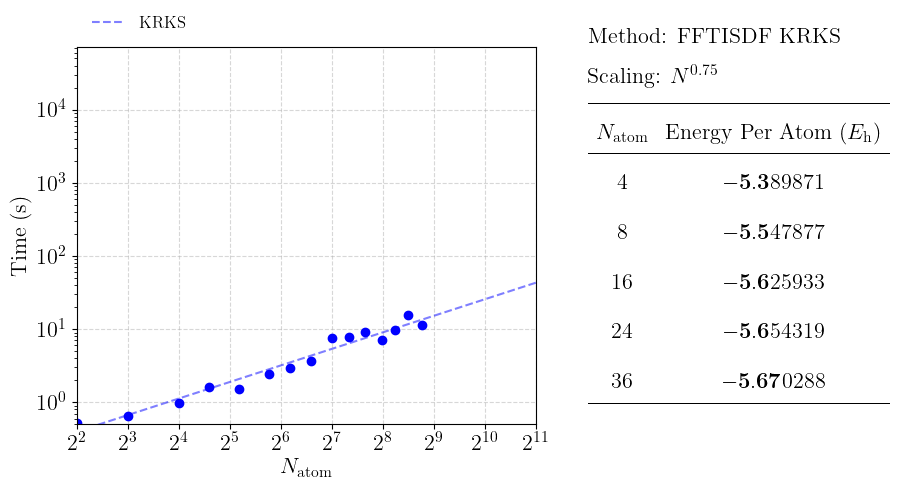

In [118]:
index = 0
table = [
    (4, 1),
    (8, 1),
    (16, 1),
    (24, 1),
    (36, 2),
]

plot_and_make_table(index, table)

krhf
[2.         3.         4.         4.5849625  5.169925   5.7548875
 6.169925   6.5849625  7.         7.32192809 7.64385619 7.96578428
 8.22881869 8.4918531  8.7548875 ] [ 0.53  0.65  0.99  1.62  1.54  2.41  2.96  3.67  7.66  7.77  9.02  7.22
  9.8  15.74 11.57]
natm =    4, e =    -5.288514
natm =    8, e =    -5.414676
natm =   16, e =    -5.478652
natm =   24, e =    -5.499939
natm =   36, e =    -5.510837
natm =   54, e =    -5.511250
natm =   72, e =    -5.514234
natm =   96, e =    -5.515229
natm =  128, e =    -5.514659
natm =  160, e =    -5.514756
natm =  200, e =    -5.514912
natm =  250, e =    -5.514310
natm =  300, e =    -5.514213
natm =  360, e =    -5.514062
natm =  432, e =    -5.513837
[2.         3.         4.         4.5849625  5.169925   5.7548875
 6.169925   6.5849625  7.         7.32192809 7.64385619 7.96578428
 8.22881869 8.4918531  8.7548875 ] [ 0.37  0.46  0.72  0.93  1.18  2.48  2.41  2.93  4.55  4.89  7.58  5.64
  5.86 11.5   8.88]


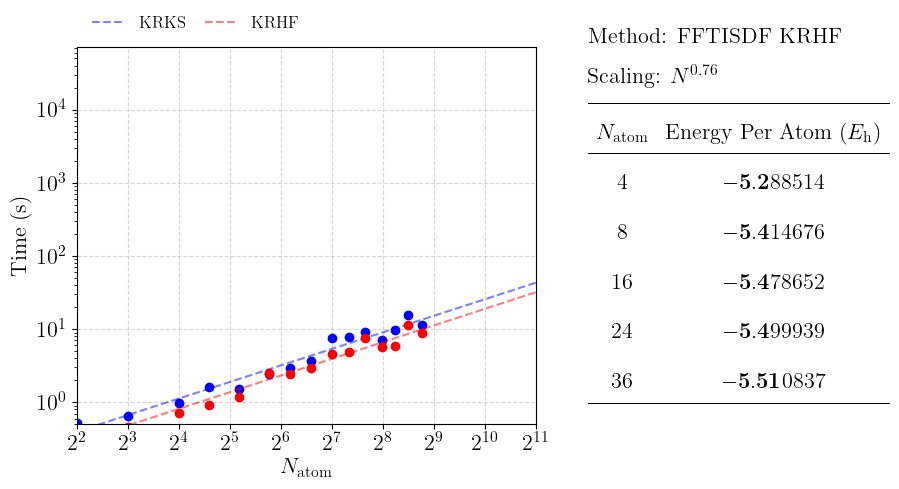

In [119]:
index = 1
table = [
    (4, 1),
    (8, 1),
    (16, 1),
    (24, 1),
    (36, 2),
]

plot_and_make_table(index, table)

kmp2
[2.         3.         4.         4.5849625  5.169925   5.7548875
 6.169925   6.5849625  7.         7.32192809 7.64385619 7.96578428
 8.22881869 8.4918531  8.7548875 ] [ 0.53  0.65  0.99  1.62  1.54  2.41  2.96  3.67  7.66  7.77  9.02  7.22
  9.8  15.74 11.57]
[2.         3.         4.         4.5849625  5.169925   5.7548875
 6.169925   6.5849625  7.         7.32192809 7.64385619 7.96578428
 8.22881869 8.4918531  8.7548875 ] [ 0.37  0.46  0.72  0.93  1.18  2.48  2.41  2.93  4.55  4.89  7.58  5.64
  5.86 11.5   8.88]
natm =    4, e =    -5.397354
natm =    8, e =    -5.529340
natm =   16, e =    -5.596222
natm =   24, e =    -5.622999
natm =   36, e =    -5.637216
natm =   54, e =    -5.638897
natm =   72, e =    -5.644439
natm =   96, e =    -5.646688
natm =  128, e =    -5.646661
natm =  160, e =    -5.647668
natm =  200, e =    -5.648506
natm =  250, e =    -5.648097
natm =  300, e =    -5.648409
natm =  360, e =    -5.648445
natm =  432, e =    -5.648377
[2.         3.         

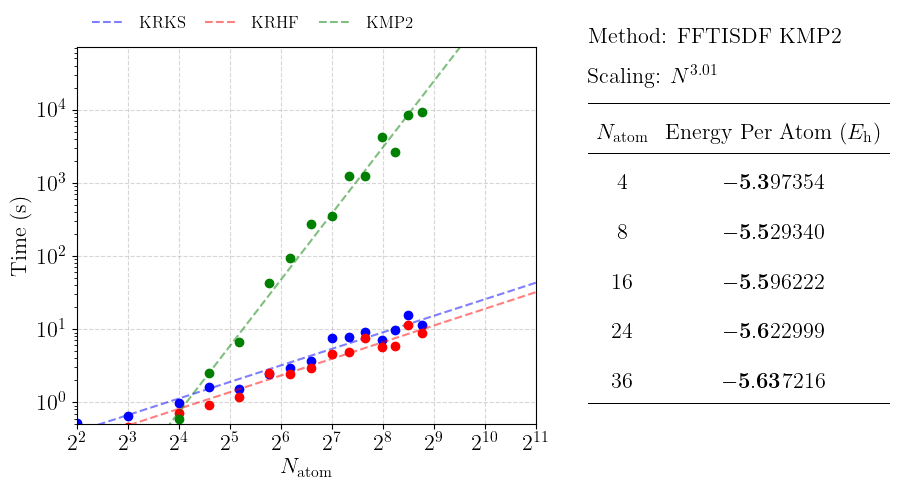

In [120]:
index = 2
table = [
    (4, 1),
    (8, 1),
    (16, 1),
    (24, 1),
    (36, 2),
]
plot_and_make_table(index, table)

kccsd
[2.         3.         4.         4.5849625  5.169925   5.7548875
 6.169925   6.5849625  7.         7.32192809 7.64385619 7.96578428
 8.22881869 8.4918531  8.7548875 ] [ 0.53  0.65  0.99  1.62  1.54  2.41  2.96  3.67  7.66  7.77  9.02  7.22
  9.8  15.74 11.57]
[2.         3.         4.         4.5849625  5.169925   5.7548875
 6.169925   6.5849625  7.         7.32192809 7.64385619 7.96578428
 8.22881869 8.4918531  8.7548875 ] [ 0.37  0.46  0.72  0.93  1.18  2.48  2.41  2.93  4.55  4.89  7.58  5.64
  5.86 11.5   8.88]
[2.         3.         4.         4.5849625  5.169925   5.7548875
 6.169925   6.5849625  7.         7.32192809 7.64385619 7.96578428
 8.22881869 8.4918531  8.7548875 ] [1.00000e-02 8.00000e-02 5.90000e-01 2.54000e+00 6.75000e+00 4.21500e+01
 9.30700e+01 2.70800e+02 3.49570e+02 1.24344e+03 1.25532e+03 4.16080e+03
 2.62625e+03 8.44757e+03 9.25874e+03]
natm =    4, e =    -5.411219
natm =    8, e =    -5.538009
natm =   16, e =    -5.602465
natm =   24, e =    -5.626051


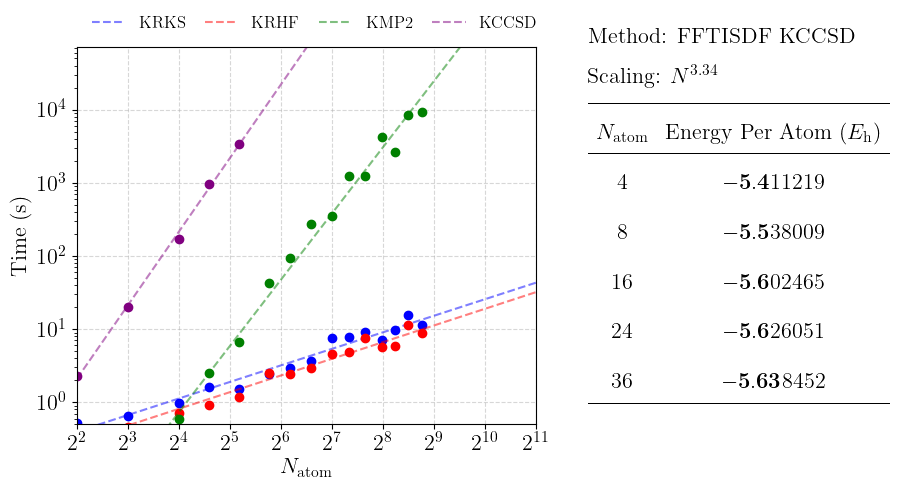

In [121]:
index = 3
table = [
    (4, 1),
    (8, 1),
    (16, 1),
    (24, 1),
    (36, 2),
]
plot_and_make_table(index, table)